In [2]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

demand_data = pd.read_csv('final project 2024-1.csv')
demand_data.head()


FileNotFoundError: [Errno 2] No such file or directory: 'final project 2024-1.csv'

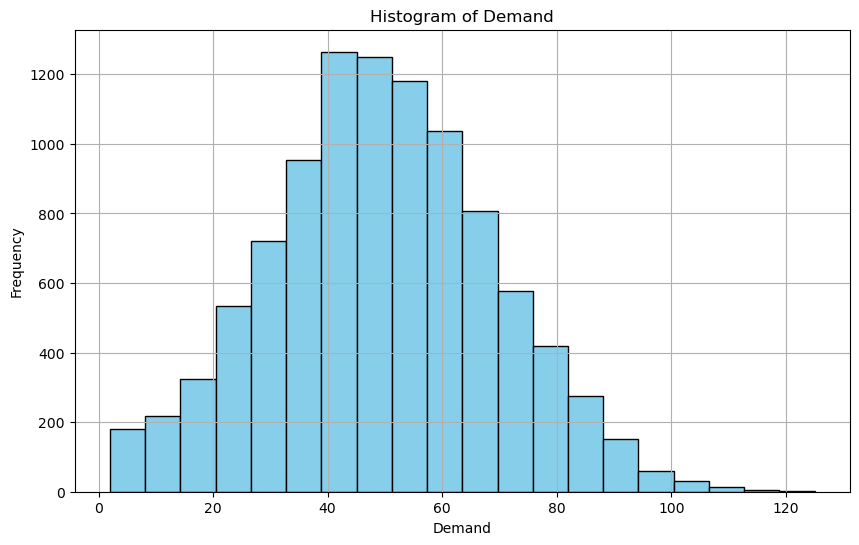

In [2]:
plt.figure(figsize=(10, 6))
plt.hist(demand_data['demand'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
mean_demand = demand_data['demand'].mean()
std_demand = demand_data['demand'].std()

# 1. Sourcing only from Mexico

In [4]:
sales_price = 10
mexico_cost = 8

# Calculating Service Level
mexico_Cu = sales_price - mexico_cost
mexico_Co = mexico_cost
mexico_lt = 1
mexico_SL = mexico_Cu/(mexico_Cu + mexico_Co)
mexico_SL

0.2

In [5]:
# Calculate Order-up-to Level (OUL)
mexico_OUL = demand_data['demand'].quantile(mexico_SL)
mexico_lt_demand = mean_demand * mexico_lt
mexico_SS = mexico_OUL - mexico_lt_demand
mexico_ROP = mexico_lt_demand + mexico_SS

# Initialize parameters for simulation
init_inv = 0
init_cash = 0
n_periods = demand_data.shape[0]

# Initialize tracking lists
inv_levels = []
cash_bal = []
orders = []

# Initialize starting values
inv = init_inv
cash = init_cash

# Interest rates
int = 0.01

In [6]:
# Run simulation for each period with interest calculations
for period in range(n_periods):
    demand = demand_data.loc[period, 'demand']
    
    # Fulfill demand from inventory
    if inv >= demand:
        sales = demand
        inv -= demand
    else:
        sales = inv
        inv = 0
    
    # Calculate revenue from sales
    revenue = sales * sales_price
    cash += revenue
    
    # Place an order to restock inventory to OUL
    order_qty = max(0, mexico_OUL - inv)
    order_cost = order_qty * mexico_cost
    inv += order_qty
    cash -= order_cost
    
    # Apply interest on cash balance or debt
    if cash >= 0:
        cash *= (1 + int)
    else:
        cash *= (1 - int)
    
    # Track inventory level and cash balance
    inv_levels.append(inv)
    cash_bal.append(cash)
    orders.append(order_qty)

In [7]:
# Initialize tracking lists for report
periods_list = []
demands = []
sales_list = []
revenues = []
order_quantities = []
order_costs = []
interests = []
inventory_levels_report = []
cash_balances_report = []

# Reinitialize starting values
inv = init_inv
cash = init_cash

# Run simulation for each period with detailed tracking
for period in range(n_periods):
    demand = demand_data.loc[period, 'demand']
    
    # Fulfill demand from inventory
    if inv >= demand:
        sales = demand
        inv -= demand
    else:
        sales = inv
        inv = 0
    
    # Calculate revenue from sales
    revenue = sales * sales_price
    cash += revenue
    
    # Place an order to restock inventory to OUL
    order_qty = max(0, mexico_OUL - inv)
    order_cost = order_qty * mexico_cost
    inv += order_qty
    cash -= order_cost
    
    # Calculate interest
    if cash >= 0:
        interest_amt = cash * int
        cash *= (1 + int)
    else:
        interest_amt = cash * -int
        cash *= (1 - int)
    
    # Track data for each period
    periods_list.append(period + 1)
    demands.append(demand)
    sales_list.append(sales)
    revenues.append(revenue)
    order_quantities.append(order_qty)
    order_costs.append(order_cost)
    interests.append(interest_amt)
    inventory_levels_report.append(inv)
    cash_balances_report.append(cash)

In [8]:
# Create a DataFrame with the relevant values for each period
report_mexico = pd.DataFrame({
    'Period': periods_list,
    'Demand': demands,
    'Sales': sales_list,
    'Revenue': revenues,
    'Order Quantity': order_quantities,
    'Order Cost': order_costs,
    'Interest': interests,
    'Inventory Level': inventory_levels_report,
    'Cash Balance': cash_balances_report
})

# Display the DataFrame
report_mexico.tail()

,Period,Demand,Sales,Revenue,Order Quantity,Order Cost,Interest,Inventory Level,Cash Balance
9995,9996,68,33.0,330.0,33.0,264.0,9.073303e+44,33.0,9.164036e+46
9996,9997,70,33.0,330.0,33.0,264.0,9.164036e+44,33.0,9.255677e+46
9997,9998,74,33.0,330.0,33.0,264.0,9.255677e+44,33.0,9.348233e+46
9998,9999,52,33.0,330.0,33.0,264.0,9.348233e+44,33.0,9.441716e+46
9999,10000,49,33.0,330.0,33.0,264.0,9.441716e+44,33.0,9.536133e+46


In [9]:
# Results with interest
mexico_end_inv = inv_levels[-1]
mexico_end_cash = cash_bal[-1]

mexico_end_inv, mexico_end_cash

(33.0, 9.536132936710321e+46)

## Mexico Plots

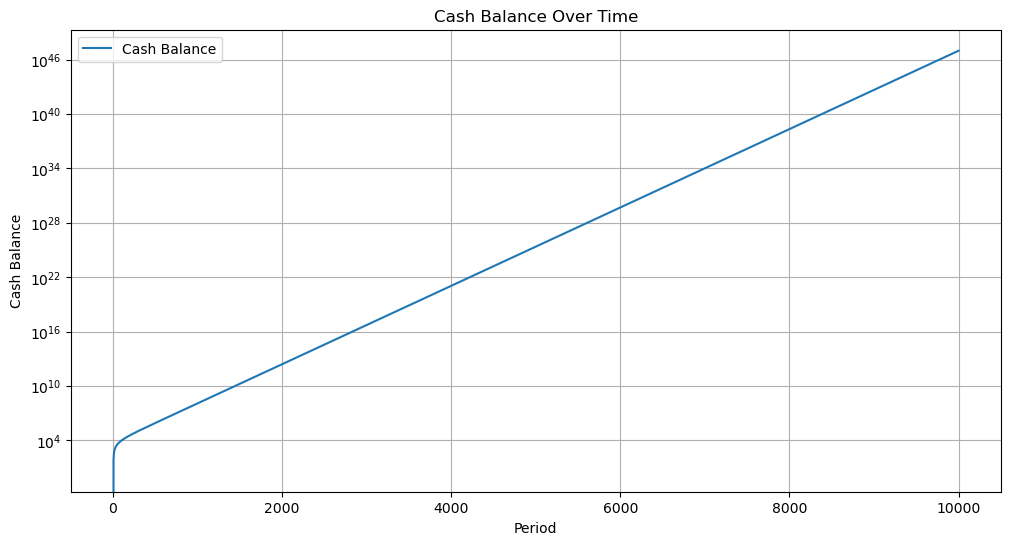

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(report_mexico['Period'], report_mexico['Cash Balance'], label='Cash Balance')
plt.xlabel('Period')
plt.ylabel('Cash Balance')
plt.title('Cash Balance Over Time')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Using log scale due to large values
plt.show()

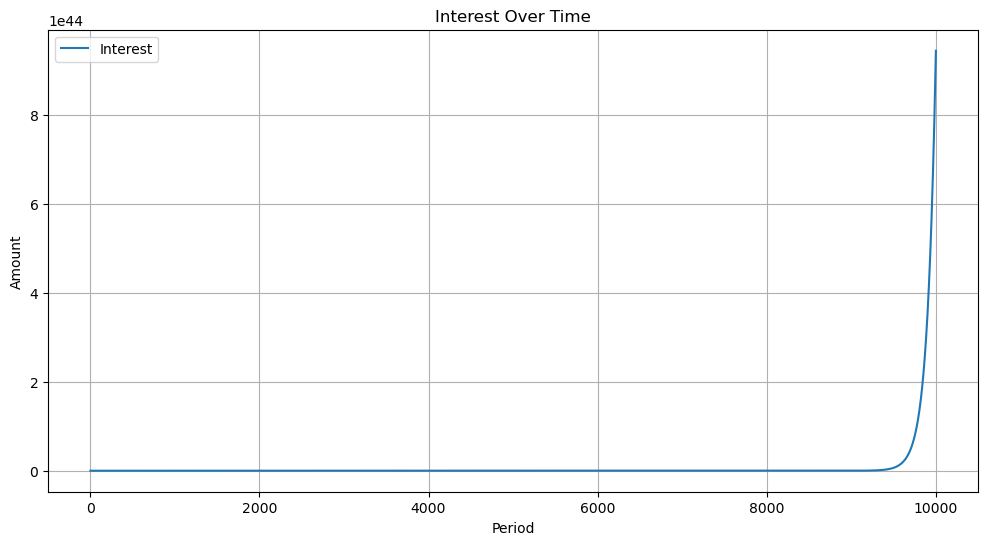

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(report_mexico['Period'], report_mexico['Interest'], label='Interest')
plt.xlabel('Period')
plt.ylabel('Amount')
plt.title('Interest Over Time')
plt.legend()
plt.grid(True)
plt.show()

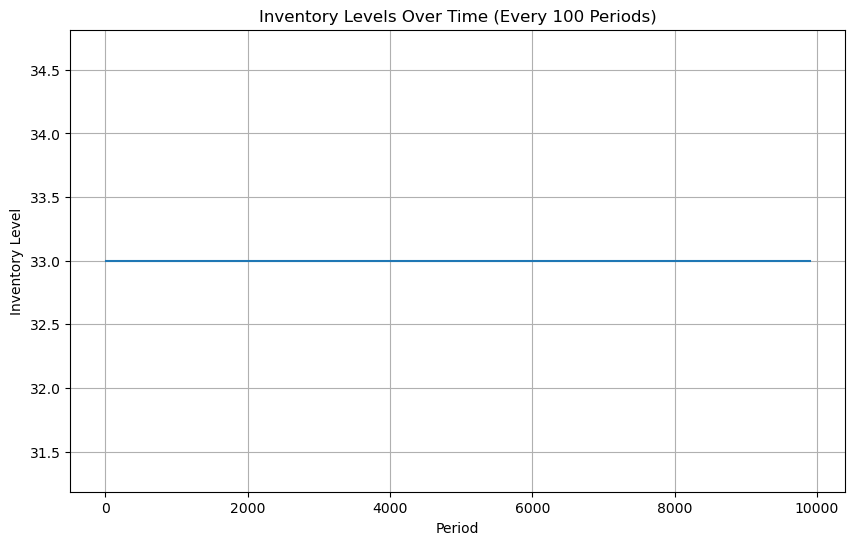

In [12]:
# Plotting the Inventory Levels
plt.figure(figsize=(10, 6))
plt.plot(report_mexico['Period'][::100], report_mexico['Inventory Level'][::100], linestyle='-')
plt.title('Inventory Levels Over Time (Every 100 Periods)')
plt.xlabel('Period')
plt.ylabel('Inventory Level')
plt.grid(True)
plt.show()

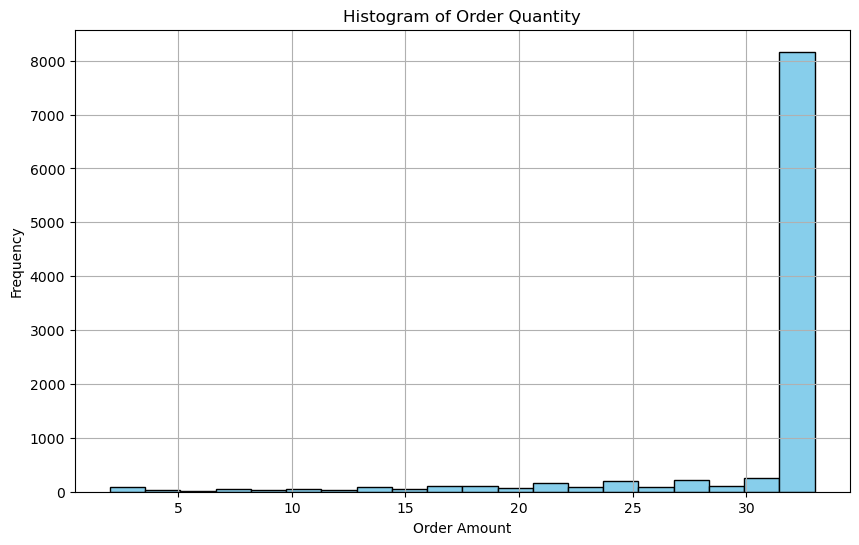

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(report_mexico['Order Quantity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Order Quantity')
plt.xlabel('Order Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Sourcing only from China

In [14]:
demand_data['lead_demand'] = demand_data['demand'].rolling(window=4).sum()
demand_data.head(10)

,period,demand,lead_demand
0,1,21,NaN
1,2,81,NaN
2,3,32,NaN
3,4,58,192.0
4,5,47,218.0
5,6,49,186.0
6,7,66,220.0
7,8,29,191.0
8,9,55,199.0
9,10,39,189.0


In [15]:
sales_price = 10
china_cost = 7.25

# Calculating Service Level
china_Cu = sales_price  - china_cost
china_Co = china_cost
china_lt = 4
china_SL = china_Cu/(china_Cu + china_Co)
china_SL

0.275

In [16]:
# Calculating ROP and OUL
china_OUL = demand_data['lead_demand'].quantile(china_SL)
china_lt_demand = mean_demand * china_lt
china_SS = china_OUL - china_lt_demand
china_ROP = china_lt_demand + china_SS

china_lt_demand, china_SS, china_ROP

(197.488, -23.488, 174.0)

In [17]:
# Initialize parameters for simulation
init_inv = 0
init_cash = 0
n_periods = demand_data.shape[0]

# Initialize tracking lists
inv_levels = []
cash_bal = []
orders = []

# Initialize starting values
inv = init_inv
cash = init_cash

period_demands = []
orders_in_transit = []
order_quantities = []
order_costs = []
interests = []
revenues = []
sales_list = []

In [18]:
# Simulate each period
for period in range(n_periods):
    current_demand = demand_data['demand'].iloc[period]
    sales = min(inv, current_demand)
    revenue = sales * sales_price
    inv-= sales
    cash+= revenue

    # Update inventory for orders that have arrived
    if period >= china_lt:
        arrived_order = orders_in_transit.pop(0) if orders_in_transit else 0
        inv += arrived_order

    # Check if we need to place a new order
    if inv < china_ROP and (inv + sum(orders_in_transit) < china_OUL):
        order_qty = china_OUL - (inv+ sum(orders_in_transit))
        order_cost = order_qty * china_cost
        # Place order, which will arrive after lead time periods
        orders_in_transit.append(order_qty)
        cash -= order_cost

    # Apply interest or debt cost to the cash balance
    if cash >= 0:
        interest_amt = cash * int
        cash *= (1 + int)
    else:
        interest_amt = cash * -int
        cash *= (1 - int)
        
    cash_bal.append(cash)
    sales_list.append(sales)
    revenues.append(revenue)
    order_quantities.append(order_qty if inv < china_ROP else 0)
    order_costs.append(order_cost)
    inv_levels.append(inv)
    interests.append(interest_amt)
    period_demands.append(current_demand)

In [19]:
# Create the DataFrame for China
report_china = pd.DataFrame({
    'Period': range(n_periods),
    'Demand': period_demands,
    'Sales': sales_list,
    'Revenue': revenues,
    'Order Quantity': order_quantities,
    'Order Cost': order_costs,
    'Interest': interests,
    'Inventory Level': inv_levels,
    'Cash Balance': cash_bal
})

# Display the DataFrame
report_china.tail()

,Period,Demand,Sales,Revenue,Order Quantity,Order Cost,Interest,Inventory Level,Cash Balance
9995,9995,68,68.0,680.0,68.0,493.00,1.780611e+45,106.0,1.798417e+47
9996,9996,70,70.0,700.0,70.0,507.50,1.798417e+45,104.0,1.816401e+47
9997,9997,74,74.0,740.0,74.0,536.50,1.816401e+45,100.0,1.834565e+47
9998,9998,52,52.0,520.0,52.0,377.00,1.834565e+45,122.0,1.852911e+47
9999,9999,49,49.0,490.0,49.0,355.25,1.852911e+45,125.0,1.871440e+47


In [20]:
# Results with interest
china_end_inv = inv_levels[-1]
china_end_cash = cash_bal[-1]

china_end_inv, china_end_cash

(125.0, 1.8714399397219125e+47)

## China Plots

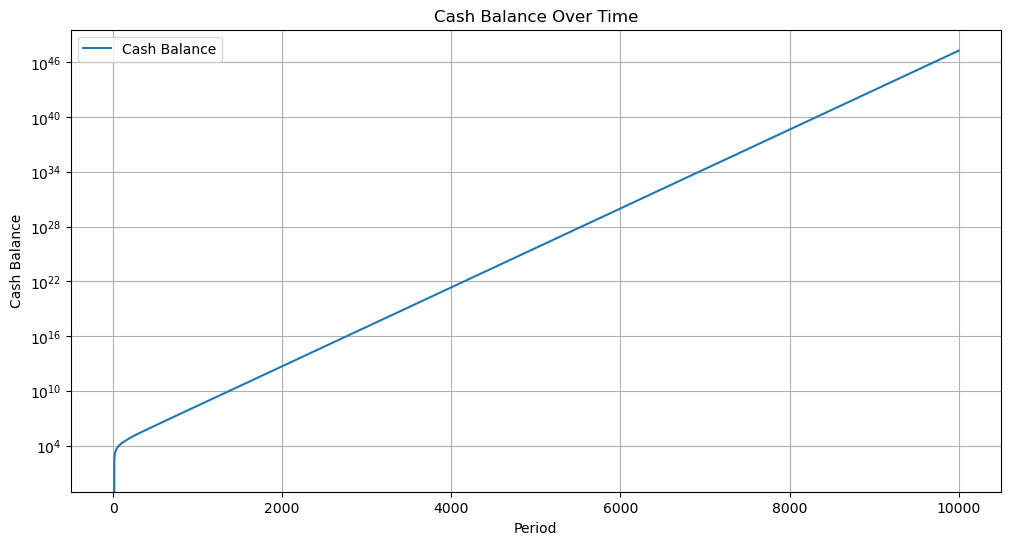

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(report_china['Period'], report_china['Cash Balance'], label='Cash Balance')
plt.xlabel('Period')
plt.ylabel('Cash Balance')
plt.title('Cash Balance Over Time')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Using log scale due to large values
plt.show()

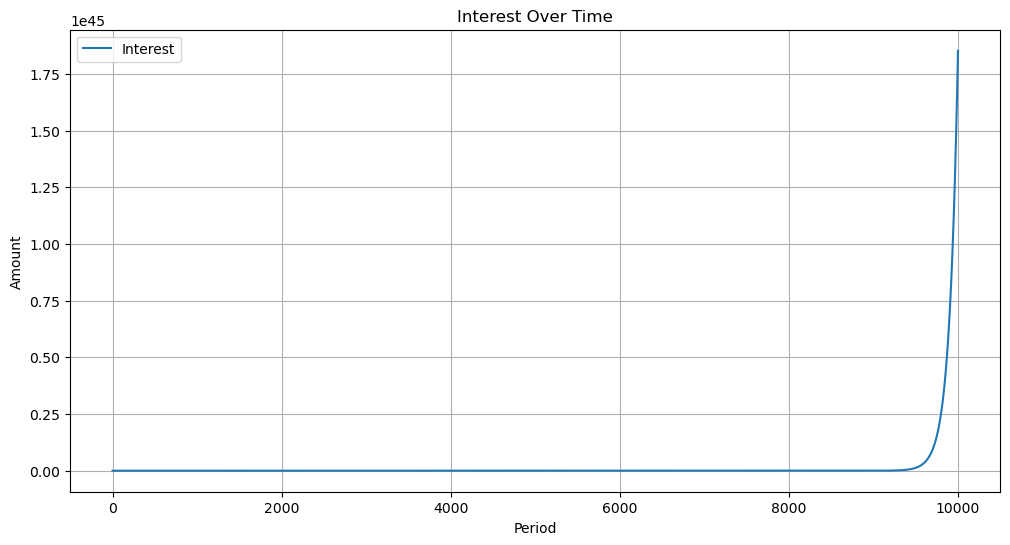

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(report_china['Period'], report_china['Interest'], label='Interest')
plt.xlabel('Period')
plt.ylabel('Amount')
plt.title('Interest Over Time')
plt.legend()
plt.grid(True)
plt.show()

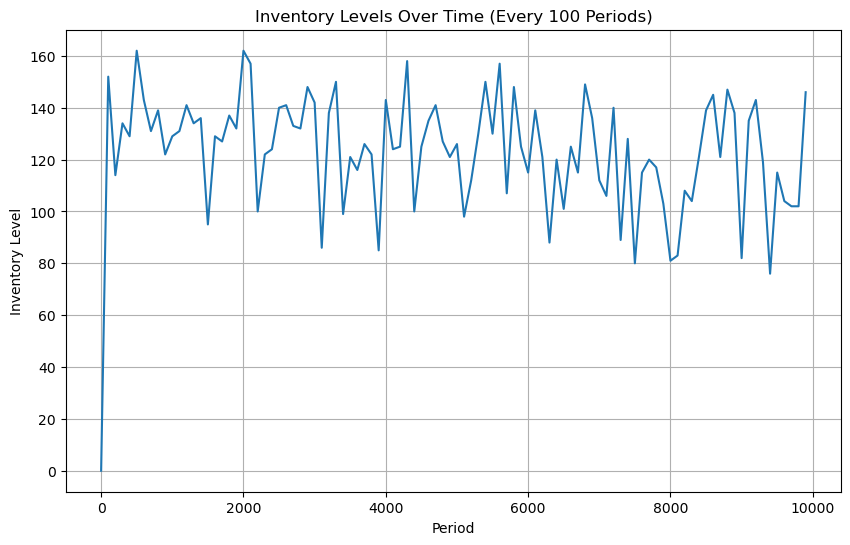

In [23]:
# Plotting the Inventory Levels
plt.figure(figsize=(10, 6))
plt.plot(report_china['Period'][::100], report_china['Inventory Level'][::100], linestyle='-')
plt.title('Inventory Levels Over Time (Every 100 Periods)')
plt.xlabel('Period')
plt.ylabel('Inventory Level')
plt.grid(True)
plt.show()

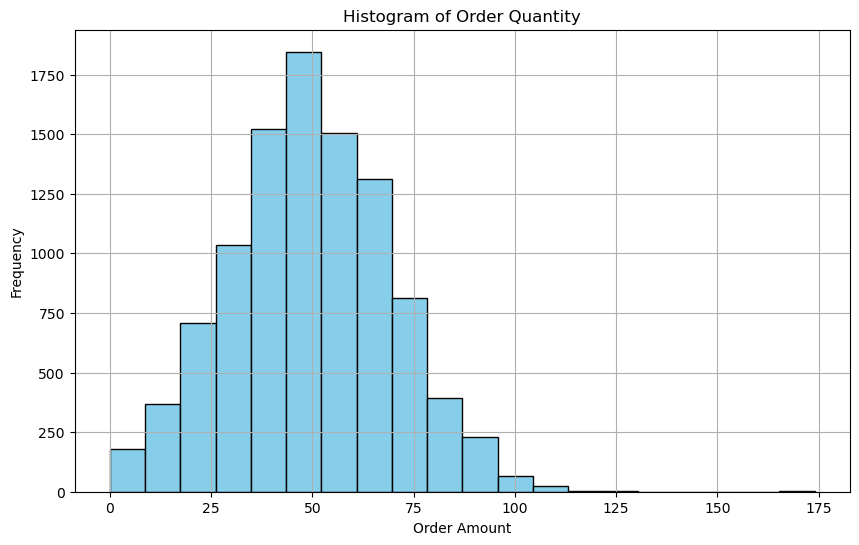

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(report_china['Order Quantity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Order Quantity')
plt.xlabel('Order Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Dual Sourcing

In [1]:
import numpy as np

# Simulation parameters
n_periods = 10000  # number of periods to simulate
initial_inventory = 0  # starting with no inventory
initial_cash = 0  # starting with no cash
mexico_ROP = 81.72815497757566  # Reorder point for Mexico
mexico_SS = 32.35615497757565  # Safety stock for Mexico
china_ROP = 262.2003099551513  # Reorder point for China
china_SS = 64.7123099551513  # Safety stock for China
mexico_lt = 1  # Lead time for Mexico orders
china_lt = 4  # Lead time for China orders
sales_price = 20  # Example sales price per unit
mexico_cost = 15  # Example cost per unit from Mexico
china_cost = 10  # Example cost per unit from China
interest_rate = 0.01  # Example interest rate

# Initialize arrays to track inventory, orders, and cash flow
inventory = np.zeros(n_periods + 1)
inventory[0] = initial_inventory
cash = np.zeros(n_periods + 1)
cash[0] = initial_cash
orders_mexico = np.zeros(n_periods)
orders_china = np.zeros(n_periods)
demand = demand_data['demand'].sample(n_periods, replace=True).values  # simulate demand for next 10000 periods

# Simulate the inventory and cash flow over the specified number of periods
for t in range(n_periods):
    # 1. Receive deliveries
    if t >= mexico_lt:
        inventory[t] += orders_mexico[t - mexico_lt]
    if t >= china_lt:
        inventory[t] += orders_china[t - china_lt]

    # 2. Calculate inventory level (already included deliveries in step 1)
    # inventory[t] is up-to-date after receiving deliveries

    # 3. See the demand at t
    current_demand = demand[t]

    # 4. Sell up to the minimum of demand and available inventory
    sales = min(current_demand, inventory[t])
    revenue = sales * sales_price
    cash[t] += revenue

    # 5. Place orders to Mexico/China if needed
    if inventory[t] < mexico_ROP:
        orders_mexico[t] = max(0, mexico_ROP - inventory[t] + mexico_SS)  # Order up to ROP + Safety Stock
    if inventory[t] < china_ROP:
        orders_china[t] = max(0, china_ROP - inventory[t] + china_SS)  # Order up to ROP + Safety Stock

    # 6. Calculate the cash balance at period t
    cost_mexico_this_period = orders_mexico[t] * mexico_cost
    cost_china_this_period = orders_china[t] * china_cost
    cash[t] -= cost_mexico_this_period + cost_china_this_period

    # Update inventory and cash for next period
    inventory[t + 1] = inventory[t] - sales
    cash[t + 1] = cash[t] * (1 + (interest_rate if cash[t] >= 0 else -interest_rate))  # apply interest or debt cost

# Resulting ending bank balance
ending_cash_balance = cash[-1]

ending_cash_balance


NameError: name 'demand_data' is not defined